In [1]:
# %%
import scanpy as sc
from matplotlib import pyplot as plt
from pandas import get_dummies
from tensorflow_probability import math as tm
tfk = tm.psd_kernels

In [2]:
from models import sf
from utils import misc,preprocess,training,postprocess,visualize

In [3]:
#%% Data loading
ad = sc.read_h5ad("simulations/bm_sp/data/S1.h5ad")
ad = ad[:,:80]
X = ad.obsm["spatial"]
#raw count data for NSF
D,Dval = preprocess.anndata_to_train_val(ad, layer="counts", train_frac=0.8,
                                         flip_yaxis=False)
Ntr,J = D["Y"].shape
Xtr = D["X"]
ad = ad[:Ntr,:]
#convert to tensorflow objects
Dtf = preprocess.prepare_datasets_tf(D,Dval=Dval)

2022-06-03 13:13:13.109354: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


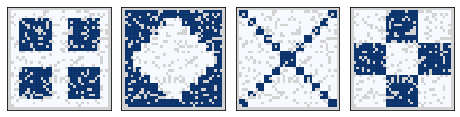

In [4]:
#%% Heatmap of true values
hmkw1 = {"figsize":(8,1.9), "bgcol":"lightgray", "subplot_space":0.1, "marker":"s",
        "s":2.9}
Ftrue = ad.obsm["spfac"]
fig,axes=visualize.multiheatmap(Xtr, Ftrue, (1,4), cmap="Blues", **hmkw1)

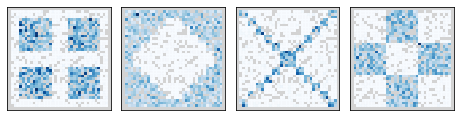

In [5]:
#%% Heatmap of sampled data
Yss = ad.layers["counts"][:,(4,0,1,2)]
fig,axes=visualize.multiheatmap(Xtr, Yss, (1,4), cmap="Blues", **hmkw1)

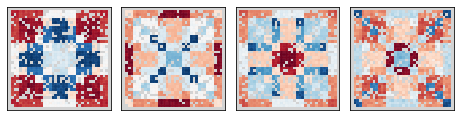

In [6]:
#%% Scanpy PCA dimension reduction
#https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html
sc.pp.pca(ad)
fig,axes=visualize.multiheatmap(Xtr, ad.obsm["X_pca"][:,:4], (1,4), cmap="RdBu",
                                **hmkw1)

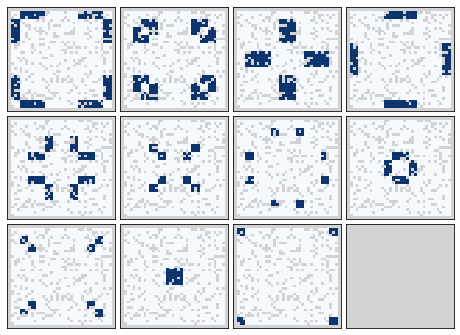

In [7]:
#%% Scanpy Leiden clustering
sc.pp.neighbors(ad)
sc.tl.umap(ad)
sc.tl.leiden(ad, resolution=1.0, key_added="clusters")
# plt.rcParams["figure.figsize"] = (4, 4)
# sc.pl.umap(ad, color="clusters", wspace=0.4)
# sc.pl.embedding(ad, "spatial", color="clusters")
cl = get_dummies(ad.obs["clusters"]).to_numpy()
fig,axes=visualize.multiheatmap(Xtr, cl, (3,4), cmap="Blues", figsize=(8,5.9),
                                bgcol="lightgray", subplot_space=0.05, 
                                marker="s", s=3.2)

In [8]:
#%% Initialize inducing points
L = 4 #number of components
Z = misc.kmeans_inducing_pts(Xtr, 500)
M = Z.shape[0] #number of inducing points
ker = tfk.MaternThreeHalves

Temporary checkpoint directory: /var/folders/_w/79p5py7d7lxbc_cgzjccyd5h0000gn/T/tmp1c9n1xvd
0050 train: 4.600e+02, val: 6.130e+02
0100 train: 4.178e+02, val: 5.913e+02
0150 train: 3.901e+02, val: 5.774e+02, chg: 1.39e-03
0200 train: 3.691e+02, val: 5.516e+02, chg: 6.71e-04
0250 train: 3.537e+02, val: 5.469e+02, chg: 9.44e-04
0300 train: 3.415e+02, val: 5.408e+02, chg: 4.83e-04
0350 train: 3.399e+02, val: 5.585e+02, chg: 6.83e-04
0400 train: 3.391e+02, val: 5.557e+02, chg: 2.23e-04
0450 train: 3.345e+02, val: 5.447e+02, chg: 2.38e-04
0500 train: 3.393e+02, val: 5.605e+02, chg: -4.27e-04
0550 train: 3.371e+02, val: 5.430e+02, chg: 2.35e-04
0600 train: 3.344e+02, val: 5.292e+02, chg: 2.03e-05
0650 train: 3.370e+02, val: 5.562e+02, chg: 3.25e-05
0650 training complete, converged.
CPU times: user 7min 15s, sys: 1min 11s, total: 8min 26s
Wall time: 3min 19s


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='epoch', ylabel='ELBO loss'>)

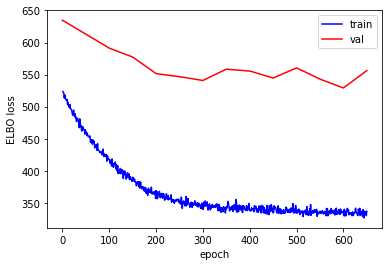

In [10]:
#%% NSF
fit = sf.SpatialFactorization(J, L, Z, psd_kernel=ker, nonneg=True, lik="poi")
fit.init_loadings(D["Y"], X=Xtr, sz=D["sz"], shrinkage=0.3)
tro = training.ModelTrainer(fit)
%time tro.train_model(*Dtf, status_freq=50) #about 3 mins
visualize.plot_loss(tro.loss)

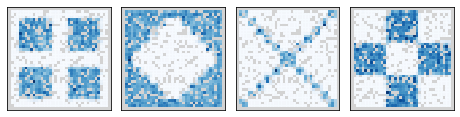

In [11]:
#%% NSF postprocessing and visualization
insf = postprocess.interpret_nsf(fit,Xtr,S=100,lda_mode=False)
Fplot = insf["factors"][:,[2,0,3,1]]
fig,axes=visualize.multiheatmap(Xtr, Fplot, (1,4), cmap="Blues", **hmkw1)

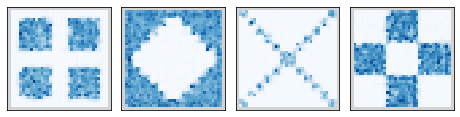

In [12]:
#%% NSF prediction on held-out observations
insf = postprocess.interpret_nsf(fit,X,S=100,lda_mode=False)
Fplot = insf["factors"][:,[2,0,3,1]]
fig,axes=visualize.multiheatmap(X, Fplot, (1,4), cmap="Blues", **hmkw1)